In [ ]:
# To generate GIFs
!pip install imageio
!pip install mtcnn
!pip install git+https://github.com/tensorflow/docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.9 MB/s eta 0:00:00
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-d5udz90f
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-d5udz90f
  Resolved https://github.com/tensorflow/docs to commit 0cc42b470815d1d15cdaefd556568fed5508bfe4
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=fc6995b2392843dba5cd1ceeb449f531183b2b23887c3196ed77da0745d13c01
  Stored in directory: /tmp/pip-ephem-wheel-cache-zw3724ta/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow_docs.vis.embed as embed
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


import tensorflow as tf
import os
from PIL import Image
import numpy as np
from mtcnn import MTCNN


import random
from PIL import Image, ImageOps, ImageEnhance

# Train GAN on B&W images

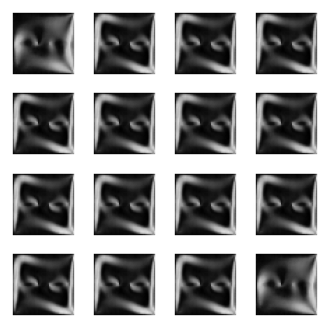

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Parse features from image names


def parse_image_name(filename):
    parts = filename[:-4].split()  # Remove '.png' extension and split by space
    velocity = float(parts[0])
    feature1 = float(parts[1])
    feature2 = float(parts[2])
    return velocity, feature1, feature2

# Load images and parse features


def load_images_and_parse_features(directory):
    images = []
    features = []

    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        image = tf.image.decode_png(tf.io.read_file(image_path), channels=1)
        image = tf.image.convert_image_dtype(image, tf.float32)
        images.append(image)
        features.append(parse_image_name(filename))

    return np.array(images), np.array(features)


# Load images and features
velocity_files_dir = "/content/drive/MyDrive/Green/velocity_files"
train_images, train_features = load_images_and_parse_features(
    velocity_files_dir)

# Normalize images to [-1, 1]
train_images = (train_images - 0.5) / 0.5

# Define constants
BUFFER_SIZE = 60000
BATCH_SIZE = 8
noise_dim = 100
num_examples_to_generate = 16

# Reshape images to match model input shape
train_images = tf.image.resize(train_images, (48, 48))

# Define the input shape for the features
feature_shape = (3,)  # Assuming 3 features: velocity, feature1, feature2

# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, train_features))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator model


def make_generator_model():
    noise_input = layers.Input(shape=(noise_dim,))
    feature_input = layers.Input(shape=feature_shape)

    merged_input = layers.Concatenate()([noise_input, feature_input])

    model = layers.Dense(6*6*256, use_bias=False)(merged_input)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU()(model)
    model = layers.Reshape((6, 6, 256))(model)

    model = layers.Conv2DTranspose(128, (5, 5), strides=(
        2, 2), padding='same', use_bias=False)(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU()(model)

    model = layers.Conv2DTranspose(64, (5, 5), strides=(
        2, 2), padding='same', use_bias=False)(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU()(model)

    generated_image = layers.Conv2DTranspose(1, (5, 5), strides=(
        2, 2), padding='same', use_bias=False, activation='tanh')(model)

    return tf.keras.Model(inputs=[noise_input, feature_input], outputs=generated_image)

# Discriminator model


def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2),
                      padding='same', input_shape=(48, 48, 1)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


# Define the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Generator loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Discriminator loss


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Checkpoint
checkpoint_dir = '/content/drive/MyDrive/Green'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training step function with noise initialization


@tf.function
def train_step(images, features):
    noise = tf.random.normal([tf.shape(images)[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, features], training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training function with early stopping


def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, features_batch in dataset:
            train_step(image_batch, features_batch)

        display.clear_output(wait=True)
        generate_and_save_images(
            generator, epoch + 1, seed, train_features[:num_examples_to_generate])

        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f"Time for epoch {epoch + 1} is {time.time() - start:.2f} sec")

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed,
                             train_features[:num_examples_to_generate])

# Generate and save images


def generate_and_save_images(model, epoch, noise_input, features_input):
    predictions = model([noise_input, features_input], training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


# Train the model
EPOCHS = 2000
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
train(train_dataset, EPOCHS)

# Save the models
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')

# Generate Image from user input

Enter Gamma:100
Enter feature 1:0.5
Enter feature 2:10.5
1/1 [==============================] - 0s 235ms/step


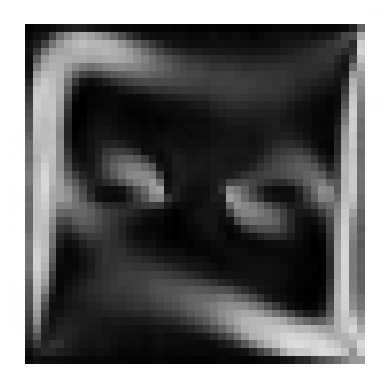

In [ ]:
# Load the models
loaded_generator = tf.keras.models.load_model('generator_model.h5')
loaded_discriminator = tf.keras.models.load_model('discriminator_model.h5')

# Compile the loaded generator model
loaded_generator.compile()

# Function to generate image based on user inputs
def generate_image(generator_model, noise_dim, gamma, feature1, feature2):
    # Prepare noise input
    noise_input = np.random.normal(size=(1, noise_dim))

    # Prepare feature input
    feature_input = np.array([[gamma, feature1, feature2]])

    # Generate image
    generated_image = generator_model.predict([noise_input, feature_input])

    return generated_image

# Example inputs
gamma = int(input("Enter Gamma:"))  # Example value for Gamma
feature1 = float(input("Enter feature 1:")) # Example value for feature1
feature2 = float(input("Enter feature 2:"))  # Example value for feature2

# Generate image based on user inputs
generated_image = generate_image(loaded_generator, noise_dim, gamma, feature1, feature2)

# Display the generated image
plt.imshow(generated_image[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.show()
